In [1]:
%load_ext autoreload
%autoreload 2
# Set-up: Import numpy and assign GPU


import os
os.environ['TRANSFORMERS_CACHE'] = '/local/helenl/.cache/'
os.environ['PYTORCH_TRANSFORMERS_CACHE'] = '/local/helenl/.cache/'

import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from tqdm.notebook import tqdm

from gpu_utils import restrict_GPU_pytorch
from helenl_utils import *

restrict_GPU_pytorch('2')

# Load Amazon WILDS pre-trained model

import statistics
import sys
import pickle
import numpy as np
import pandas as pd
import statistics
import json
import random


import torch
import torchvision.transforms as transforms

import argparse
import pdb


from wordcloud import WordCloud
import itertools

Using GPU:2


In [2]:
"""
Creates .npy files averaging predictions of multi-sample augmentations with 1 sample of the control.

Parameters:
    path_to_pred_file (string)     : The full path to the original multi-sample prediction file.
    num_samples (int)              : The number of samples used for generating predictions with the augmentation. 

"""


def average_multiple_sample_accuracies(path_to_pred_file, num_samples = 4, with_bert = True):
    
    sample_group_averages = []
    sample_group_labels = []
    sample_group_metadata = []
    
    with open(path_to_pred_file, 'rb') as file:
        logit_predictions = np.load(file, allow_pickle = True)
        labels = np.load(file, allow_pickle = True)
        meta_data = np.load(file, allow_pickle = True)
        
    print(len(logit_predictions))
    print(len(labels))
    print(len(meta_data))
    
    if with_bert:
        with open('./data/ERM_predictions/bert.npy', 'rb') as file:
            control_logit_predictions = np.load(file, allow_pickle = True)
    
    start = 0
    stop = num_samples
    
    num_comments = int(len(logit_predictions)/num_samples)

    for i in range(num_comments):
        start = i*num_samples
        stop = (i+1)*num_samples 

        sample_group = logit_predictions[start:stop]
        
        if with_bert:
            control_logit_prediction = control_logit_predictions[i]
            sample_group = np.vstack([sample_group, control_logit_prediction])
            
        sample_logit_average = np.average(sample_group, axis = 0)
        sample_group_averages.append(sample_logit_average)
        
        start += num_samples
        stop += num_samples
    
    sample_group_labels = labels[::num_samples]
    sample_group_metadata = meta_data[::num_samples]
    
    
    assert start == len(logit_predictions), "sample batches incrementing incorrectly"

    assert len(sample_group_averages) == len(logit_predictions)/num_samples, "sample batches split incorrectly"
    
    assert len(sample_group_labels) == len(sample_group_averages), "label count does not match sample group count"
    
    assert len(sample_group_metadata) == len(sample_group_averages), "metadata count does not match sample group count"
    
    if with_bert:
        averaged_sample_group_file = path_to_pred_file.replace('raw', 'averaged_sample_group/with_bert', 1) 
    
    else:
        averaged_sample_group_file = path_to_pred_file.replace('raw', 'averaged_sample_group/without_bert', 1) 


    

    with open(averaged_sample_group_file, 'wb+') as file:
        np.save(file, sample_group_averages)
        np.save(file, sample_group_labels)
        np.save(file, sample_group_metadata)
        #np.save(file, parameters)

        


In [46]:
"""
Create graph comparing accuracy of all supported augmentations

Parameters:
    augmentation_file_paths (list) :     list of strings, each corresponding to a                                          supported augmentation
    
    plot_type (string)             :     type of accuracy graph to be generated,                                          either "line" for line graph, "box" for                                          boxplot, or "bar" for bar graph
    
    
    
    
"""

def create_accuracy_graph(augmentation_file_paths
                          , plot_type = 'line'
                          , title = ''
                          , sampling_percent = 0.8
                          , num_runs = 10
                          , plot = True
                          , apply_threshhold = False):
    
    aug_to_acc = []
    for file_name in augmentation_file_paths:

        augmentation_name = file_name.split('/')[-1].split('.')[0]
        print(augmentation_name)
        accuracies = calculate_accuracy(file_name, sampling_percent = sampling_percent, num_runs = num_runs)
        
        for i in range(len(accuracies)):
            accuracy = accuracies[i]
            aug_dict = {"augmentation":augmentation_name, "accuracy": accuracy, "batch_num": i}
            aug_to_acc.append(aug_dict)

    
    acc_df = pd.DataFrame(aug_to_acc).sort_values('accuracy', ascending = False)
    #print(acc_df)
    
    

    
    if apply_threshhold:
        threshhold_value = acc_df.loc[(acc_df["augmentation"] == "bert")]["accuracy"].mean()
        #print(threshhold_value)
        filtered_acc_df = acc_df.loc[(acc_df['accuracy'] >= threshhold_value)]
        
    else:
        filtered_acc_df = acc_df
    
    
    if plot:
        sns.set(font_scale = 2)
        fig, ax = plt.subplots()

        if plot_type == 'bar':
            p = sns.barplot(x = 'augmentation', y = 'accuracy', data = filtered_acc_df, ax = ax, ci = 95)

        elif plot_type == 'box':
            p = sns.boxplot(x = 'augmentation', y = 'accuracy', data = filtered_acc_df, ax = ax)#, order = acc_df['augmentation'])


        elif plot_type == 'line':
            acc_df = pd.DataFrame(aug_to_acc).sort_values("num_samples", ascending = False)
            p = sns.lineplot(x = "augmentation", y = "accuracy", data = filtered_acc_df, ax = ax)


        min_value = filtered_acc_df.min()['accuracy']
        max_value = filtered_acc_df.max()['accuracy']

        ax.set_ylim(min_value - 0.02, min(1.0, max_value + 0.02))


        show_values(p)
        plt.rcParams['figure.figsize'] = (80,20)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        plt.title(title)
        plt.show()
    
    return filtered_acc_df



In [61]:
"""
aug_file_dir = './data/civilcomments_ERM_predictions_optimized_params_four_samples/raw/'

for file in os.listdir(aug_file_dir):
    full_path = aug_file_dir + file
    
    if full_path.split('.')[-1] == 'npy':
        print(full_path)
        average_multiple_sample_accuracies(full_path, with_bert = False)
"""



./data/civilcomments_ERM_predictions_optimized_params_four_samples/raw/nlp_random_contextual_word_insertion_squeezebert_uncased_embedding.npy
535128
535128
535128
./data/civilcomments_ERM_predictions_optimized_params_four_samples/raw/nlp_random_contextual_word_insertion_distilbert_cased_embedding.npy
535128
535128
535128
./data/civilcomments_ERM_predictions_optimized_params_four_samples/raw/nlp_random_contextual_word_substitution_bert_uncased_embedding.npy
535128
535128
535128
./data/civilcomments_ERM_predictions_optimized_params_four_samples/raw/nlp_random_contextual_word_insertion_bert_cased_embedding.npy
535128
535128
535128
./data/civilcomments_ERM_predictions_optimized_params_four_samples/raw/nlp_random_contextual_word_insertion_distilbert_uncased_embedding.npy
535128
535128
535128
./data/civilcomments_ERM_predictions_optimized_params_four_samples/raw/nlp_random_contextual_word_insertion_roberta_base_embedding.npy
535128
535128
535128
./data/civilcomments_ERM_predictions_optimized

In [5]:
file_paths = []

aug_file_dir = './data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/'

for file in os.listdir(aug_file_dir):
    full_path = aug_file_dir + file
    
    if full_path.split('.')[-1] == 'npy':
        print(full_path)
        file_paths.append(full_path)



./data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_random_contextual_word_insertion_squeezebert_uncased_embedding.npy
./data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_random_word_delete.npy
./data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_antonym.npy
./data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_random_contextual_word_insertion_distilbert_cased_embedding.npy
./data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_wordnet_synonym.npy
./data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_random_char_insert.npy
./data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_random_contextual_word_substitution_bert_uncased_

In [6]:
char_file_paths = []
word_file_paths = []


char_augs = set(['nlp_ocr'
                           , 'nlp_keyboard'
                           , 'nlp_random_char_insert'
                           , 'nlp_random_char_substitution'
                           , 'nlp_random_char_swap'
                           , 'nlp_random_char_deletion'
                           , 'nlp_spelling_substitution'])

word_augs = set(['nlp_random_word_swap'
                           , 'nlp_random_word_delete'
                           , 'nlp_random_word_substitute'
                           , 'nlp_random_token_split'
                           , 'nlp_wordnet_synonym'
                           , 'nlp_ppdb_synonym'
                           , 'nlp_antonym'
                           , 'nlp_random_contextual_word_insertion_bert_uncased_embedding'
                           , 'nlp_random_contextual_word_insertion_bert_cased_embedding'
                           , 'nlp_random_contextual_word_insertion_distilbert_uncased_embedding'
                           , 'nlp_random_contextual_word_insertion_distilbert_cased_embedding'
                           , 'nlp_random_contextual_word_insertion_roberta_base_embedding'
                           , 'nlp_random_contextual_word_insertion_distilroberta_base_embedding'
                           , 'nlp_random_contextual_word_insertion_bart_base_embedding'
                           , 'nlp_random_contextual_word_insertion_squeezebert_uncased_embedding'
                           , 'nlp_random_contextual_word_substitution_bert_uncased_embedding'
                           , 'nlp_random_contextual_word_substitution_bert_cased_embedding'
                           , 'nlp_random_contextual_word_substitution_distilbert_uncased_embedding'
                           , 'nlp_random_contextual_word_substitution_distilbert_cased_embedding'
                           , 'nlp_random_contextual_word_substitution_roberta_embedding'
                           , 'nlp_random_contextual_word_substitution_distilroberta_base_embedding'
                           , 'nlp_random_contextual_word_substitution_bart_base_embedding'
                           , 'nlp_random_contextual_word_substitution_squeezebert_uncased_embedding'
    
])

for file_path in file_paths:
    aug = file_path.split('/')[-1].split('.')[0]
    
    if aug in char_augs:
        char_file_paths.append(file_path)
            
    elif aug in word_augs:
        word_file_paths.append(file_path)
            
            
            
    




In [8]:
char_file_paths.append('./data/ERM_predictions/bert.npy')

In [7]:
char_file_paths

['./data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_random_char_insert.npy',
 './data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_random_char_substitution.npy',
 './data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_spelling_substitution.npy',
 './data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_ocr.npy',
 './data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_keyboard.npy',
 './data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_random_char_swap.npy',
 './data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/without_bert/nlp_random_char_deletion.npy']

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0.9264573697734173


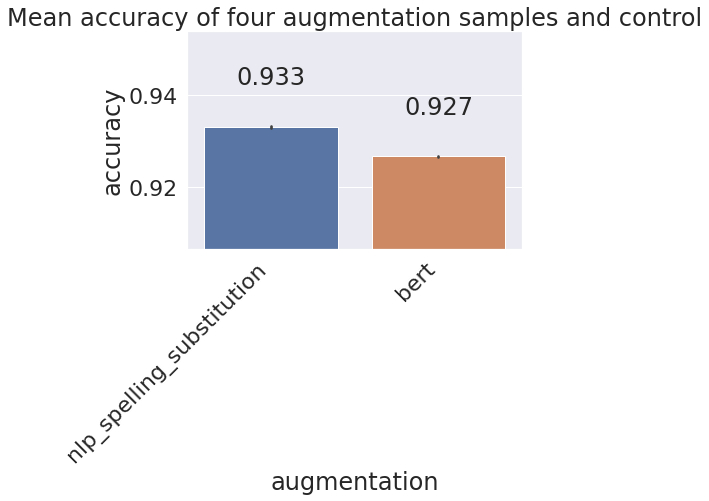

In [21]:
create_accuracy_graph(char_file_paths, "bar", "Mean accuracy of four augmentation samples and control")

In [6]:
word_file_paths.append('./data/ERM_predictions/bert.npy')

In [50]:
word_file_paths

['./data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/nlp_random_contextual_word_insertion_squeezebert_uncased_embedding.npy',
 './data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/nlp_random_word_delete.npy',
 './data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/nlp_antonym.npy',
 './data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/nlp_random_contextual_word_insertion_distilbert_cased_embedding.npy',
 './data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/nlp_wordnet_synonym.npy',
 './data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/nlp_random_contextual_word_substitution_bert_uncased_embedding.npy',
 './data/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/nlp_rand

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.9265779023592619


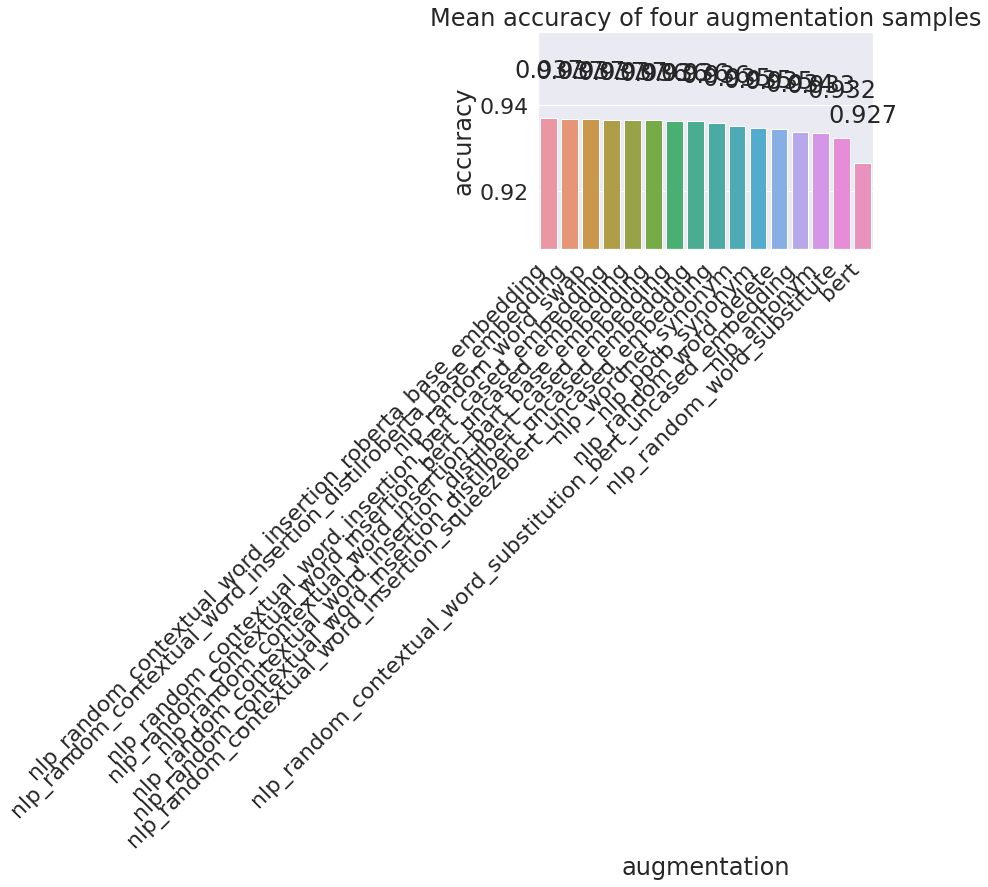

In [8]:
create_accuracy_graph(word_file_paths, "bar", "Mean accuracy of four augmentation samples", num_runs = 1)

In [7]:
"""
Creates .npy files averaging predictions of multiple different augmentations.
 

Parameters:
    paths_to_pred_file (list)      : List of full paths to the original prediction files.
                                     The files must contain the same number of samples for each augmentation. 
                                     
                                     
    num_samples (int)              : The number of samples used for generating predictions with the augmentation. 

"""


def average_different_aug_accuracies(paths_to_pred_file
                                     , averaged_file_directory
                                     , num_samples = 1
                                     , augs_combo_id = None
):
    
    sample_group_averages = []
    sample_group_labels = []
    sample_group_metadata = []
    
    all_logit_predictions = []
    labels = []
    meta_data = []
    
    
    for i in range(len(paths_to_pred_file)):
        
        path = paths_to_pred_file[i]
        
        with open(path, 'rb') as file:
            
            logit_predictions = np.load(file, allow_pickle = True)
            all_logit_predictions.append(logit_predictions)
            
            if i == 0:
                labels = np.load(file, allow_pickle = True)
                meta_data = np.load(file, allow_pickle = True)
     
        
    all_logit_predictions = np.array(all_logit_predictions)
    

    logit_average_across_augmentations = np.average(all_logit_predictions, axis = 0)
    
    
    
    assert len(labels) == len(logit_average_across_augmentations), "label count does not match sample group count"
    
    assert len(meta_data) == len(logit_average_across_augmentations), "metadata count does not match sample group count"
    
    
    averaged_file_path = averaged_file_directory + str(augs_combo_id) + ".npy"


    with open(averaged_file_path, 'wb+') as file:
        np.save(file, logit_average_across_augmentations)
        np.save(file, labels)
        np.save(file, meta_data)
        #np.save(file, parameters)
    
    
    """
    start = 0
    stop = num_samples
    
    while start < len(logit_predictions):
        sample_group = logit_predictions[start:stop]
        
        sample_logit_average = np.average(sample_group, axis = 0)
        sample_group_averages.append(sample_logit_average)
        
        start += num_samples
        stop += num_samples
    
    sample_group_labels = labels[::num_samples]
    sample_group_metadata = meta_data[::num_samples]
    
    


     """   



In [18]:
char_aug_augmentation_pairs = []
word_aug_augmentation_pairs = []
word_aug_augmentation_pairs_2 = []

char_augs_list = list(char_augs)
word_augs_list = list(word_augs)

for i in range(len(char_augs_list)):
    for j in range(i+1, len(char_augs_list)):
        pair = (char_augs_list[i], char_augs_list[j])
        
        char_aug_augmentation_pairs.append(pair)



for i in range(len(word_augs_list)):
    for j in range(i+1, len(word_augs_list)):
        pair = (word_augs_list[i], word_augs_list[j])
        
        word_aug_augmentation_pairs.append(pair)
    

In [9]:
char_aug_augmentation_pairs

[('nlp_ocr', 'nlp_random_char_swap'),
 ('nlp_ocr', 'nlp_random_char_substitution'),
 ('nlp_ocr', 'nlp_spelling_substitution'),
 ('nlp_ocr', 'nlp_random_char_deletion'),
 ('nlp_ocr', 'nlp_random_char_insert'),
 ('nlp_ocr', 'nlp_keyboard'),
 ('nlp_random_char_swap', 'nlp_random_char_substitution'),
 ('nlp_random_char_swap', 'nlp_spelling_substitution'),
 ('nlp_random_char_swap', 'nlp_random_char_deletion'),
 ('nlp_random_char_swap', 'nlp_random_char_insert'),
 ('nlp_random_char_swap', 'nlp_keyboard'),
 ('nlp_random_char_substitution', 'nlp_spelling_substitution'),
 ('nlp_random_char_substitution', 'nlp_random_char_deletion'),
 ('nlp_random_char_substitution', 'nlp_random_char_insert'),
 ('nlp_random_char_substitution', 'nlp_keyboard'),
 ('nlp_spelling_substitution', 'nlp_random_char_deletion'),
 ('nlp_spelling_substitution', 'nlp_random_char_insert'),
 ('nlp_spelling_substitution', 'nlp_keyboard'),
 ('nlp_random_char_deletion', 'nlp_random_char_insert'),
 ('nlp_random_char_deletion', 'nl

In [81]:
for pair in char_aug_augmentation_pairs:
    paths_to_aug_predictions = []
    
    if 'nlp_spelling_substitution' not in pair:
        for aug in pair:
            path = './data/ERM_predictions_optimized_params/' + aug + '.npy'
            paths_to_aug_predictions.append(path)
            
        paths_to_aug_predictions.append('./data/ERM_predictions/bert.npy')

        average_different_aug_accuracies(paths_to_aug_predictions
                                        , './data/ERM_predictions_optimized_params/single_sample_multi_aug/')

./data/ERM_predictions_optimized_params/single_sample_multi_aug/nlp_random_char_insert+nlp_random_char_swap+bert.npy
./data/ERM_predictions_optimized_params/single_sample_multi_aug/nlp_random_char_insert+nlp_random_char_deletion+bert.npy
./data/ERM_predictions_optimized_params/single_sample_multi_aug/nlp_random_char_insert+nlp_keyboard+bert.npy
./data/ERM_predictions_optimized_params/single_sample_multi_aug/nlp_random_char_insert+nlp_random_char_substitution+bert.npy
./data/ERM_predictions_optimized_params/single_sample_multi_aug/nlp_random_char_insert+nlp_ocr+bert.npy
./data/ERM_predictions_optimized_params/single_sample_multi_aug/nlp_random_char_swap+nlp_random_char_deletion+bert.npy
./data/ERM_predictions_optimized_params/single_sample_multi_aug/nlp_random_char_swap+nlp_keyboard+bert.npy
./data/ERM_predictions_optimized_params/single_sample_multi_aug/nlp_random_char_swap+nlp_random_char_substitution+bert.npy
./data/ERM_predictions_optimized_params/single_sample_multi_aug/nlp_random_

In [17]:
plotted_accuracies = []

directory = './data/civilcomments_ERM_predictions_optimized_params/single_sample_four_optimized_aug/word_based/'
for file in os.listdir(directory):
    if file.split('.')[-1] == 'npy':
        plotted_accuracies.append(directory + file)



plotted_accuracies.append('./data/civilcomments_ERM_predictions/bert.npy')


create_accuracy_graph(plotted_accuracies, num_runs = 1, plot = False)

  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


  0%|          | 0/1 [00:00<?, ?it/s]

[47508 17042 45006 ... 50012 51657 98877]


KeyboardInterrupt: 

In [24]:
"""
# Generates all combinations and hashes them to an ID value, which is saved along with combination accuracies.


combo_id_to_combo = {}

pair_id = 1

for pair in word_aug_augmentation_pairs:
    paths_to_aug_predictions = []
    
    for aug in pair:
        path = './data/ERM_predictions_optimized_params/raw/' + aug + '.npy'
        paths_to_aug_predictions.append(path)

    paths_to_aug_predictions.append('./data/ERM_predictions/bert.npy')
    
    combo = pair + ('bert',)
    combo_id_to_combo[pair_id] = combo
    
    average_different_aug_accuracies(paths_to_aug_predictions
                                    , './data/ERM_predictions_optimized_params/single_sample_two_optimized_aug/word_based/'
                                    , augs_combo_id = pair_id)
    
    pair_id += 1
    
with open("./data/ERM_predictions_optimized_params/single_sample_two_optimized_aug/word_based/combo_id_to_combo.txt", 'w') as file:
    file.write(json.dumps(combo_id_to_combo))
    
"""

78


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

    augmentation  accuracy  batch_num
251           59  0.927036          1
735           50  0.927017          5
155           42  0.927008          5
235           57  0.926952          5
737           50  0.926952          7
..           ...       ...        ...
369            6  0.925345          9
519           40  0.925335          9
329           73  0.925326          9
426           66  0.925260          6
429           66  0.925111          9

[790 rows x 3 columns]


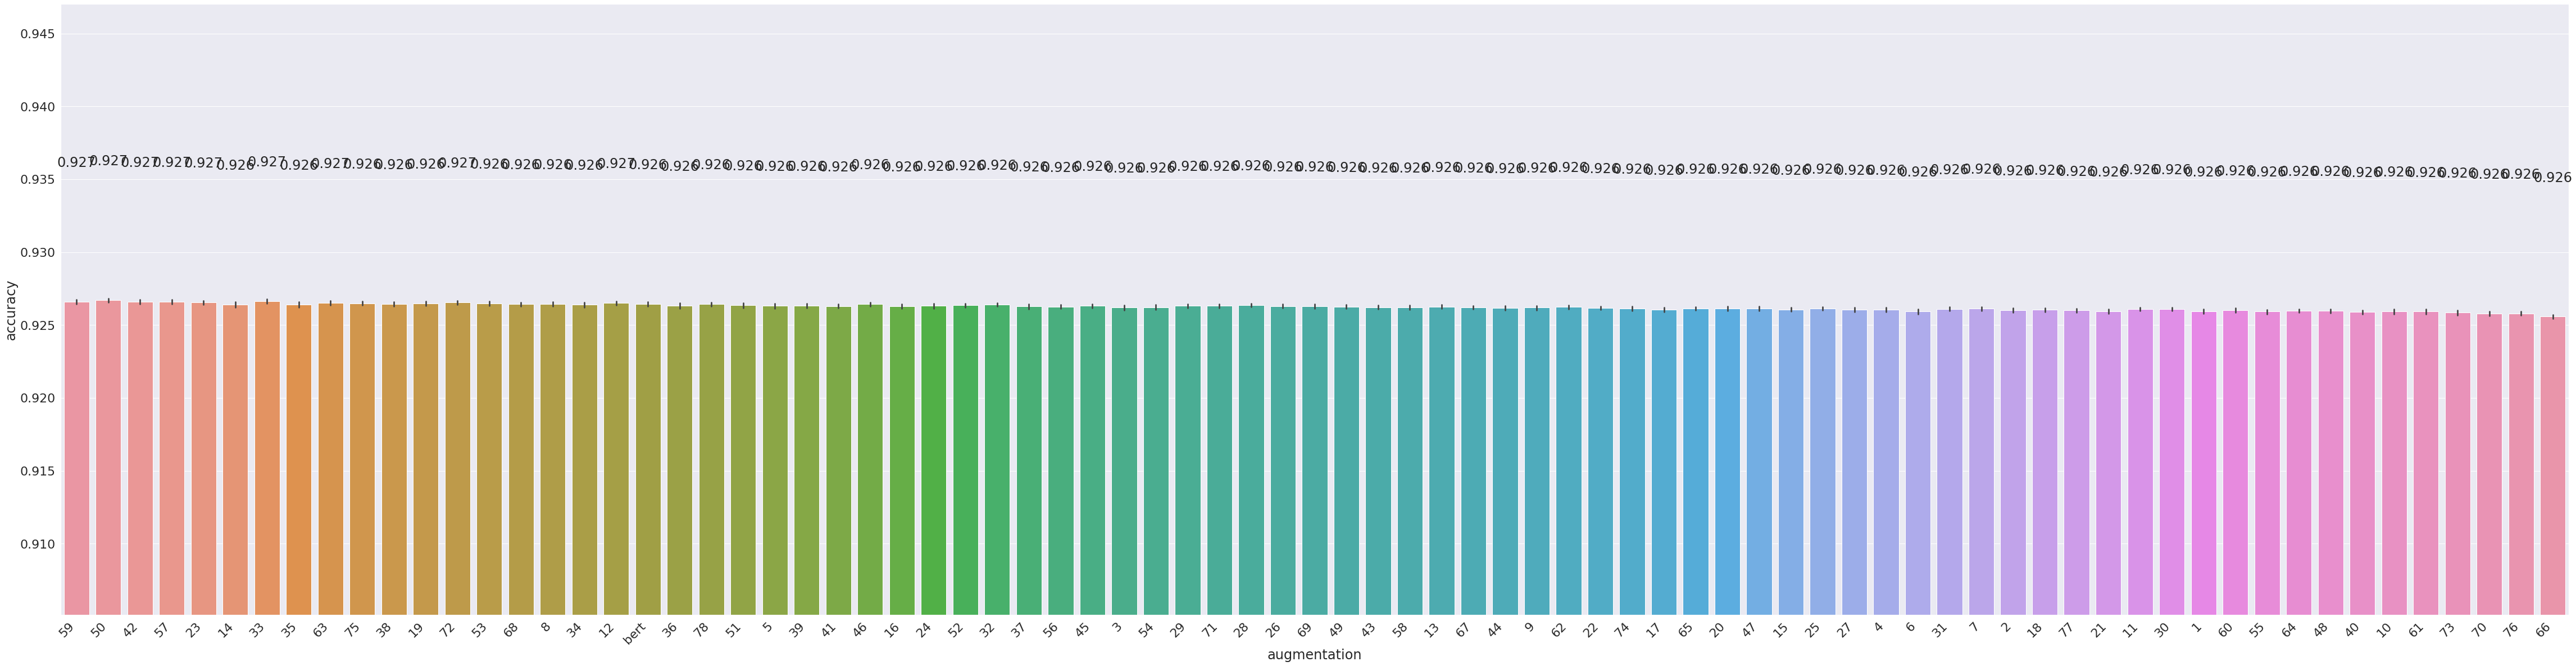

In [33]:
plotted_accuracies = []

directory = './data/ERM_predictions_optimized_params/single_sample_two_optimized_aug/word_based/'
for file in os.listdir(directory):
    if file.split('.')[-1] == 'npy':
        plotted_accuracies.append(directory + file)

print(len(plotted_accuracies))

plotted_accuracies.append('./data/ERM_predictions/bert.npy')


create_accuracy_graph(plotted_accuracies, "bar")

In [36]:
with open("./data/ERM_predictions_optimized_params/single_sample_two_optimized_aug/word_based/combo_id_to_combo.txt", 'r') as file:
    combo_dict = json.load(file)
    

improved_combo_ids = [59, 50, 42, 57, 23, 14, 33, 35, 63, 75, 38, 19, 72, 53, 68, 8, 34, 12]
improved_combos = []

for combo_id in improved_combo_ids:
    improved_combo = combo_dict[str(combo_id)]
    improved_combos.append(improved_combo)
    
print(improved_combos)

[['nlp_random_contextual_word_insertion_distilroberta_base_embedding', 'nlp_random_token_split', 'bert'], ['nlp_random_contextual_word_insertion_distilbert_uncased_embedding', 'nlp_ppdb_synonym', 'bert'], ['nlp_antonym', 'nlp_ppdb_synonym', 'bert'], ['nlp_random_word_swap', 'nlp_ppdb_synonym', 'bert'], ['nlp_random_contextual_word_insertion_bert_cased_embedding', 'nlp_ppdb_synonym', 'bert'], ['nlp_random_contextual_word_insertion_bert_cased_embedding', 'nlp_antonym', 'bert'], ['nlp_random_contextual_word_insertion_distilbert_cased_embedding', 'nlp_ppdb_synonym', 'bert'], ['nlp_antonym', 'nlp_random_word_swap', 'bert'], ['nlp_random_contextual_word_insertion_distilroberta_base_embedding', 'nlp_ppdb_synonym', 'bert'], ['nlp_random_contextual_word_insertion_roberta_base_embedding', 'nlp_ppdb_synonym', 'bert'], ['nlp_antonym', 'nlp_random_token_split', 'bert'], ['nlp_random_contextual_word_insertion_bert_cased_embedding', 'nlp_random_token_split', 'bert'], ['nlp_random_token_split', 'nlp_p

In [9]:
import itertools

char_aug_quads = []
word_aug_quads = []

char_augs_list = list(char_augs)
word_augs_list = list(word_augs)


for comb in itertools.combinations(char_augs_list, 4):
    char_aug_quads.append(comb)
    
for comb in itertools.combinations(word_augs_list, 4):
    word_aug_quads.append(comb)
    

In [41]:
len(word_aug_quads)

715

In [42]:
len(word_augs_list)

13

In [46]:
"""
# Generates all quad combinations and hashes them to an ID value, which is saved along with combination accuracies.

combo_id_to_combo = {}

quad_id = 1

for quad in char_aug_quads:
    paths_to_aug_predictions = []
    
    for aug in quad:
        path = './data/civilcomments_ERM_predictions_optimized_params/raw/' + aug + '.npy'
        paths_to_aug_predictions.append(path)

    paths_to_aug_predictions.append('./data/civilcomments_ERM_predictions/bert.npy')

    
    average_different_aug_accuracies(paths_to_aug_predictions
                                    , './data/civilcomments_ERM_predictions_optimized_params/single_sample_four_optimized_aug/char_based/'
                                    , augs_combo_id = quad_id)
    
    combo = quad + ('bert',)
    combo_id_to_combo[quad_id] = combo
    quad_id +=1
    

with open("./data/ERM_predictions_optimized_params/single_sample_four_optimized_aug/char_based/combo_id_to_combo.txt", 'w') as file:
    file.write(json.dumps(combo_id_to_combo))
"""

In [47]:
combo_id_to_combo

{1: ('nlp_ocr',
  'nlp_random_char_swap',
  'nlp_random_char_substitution',
  'nlp_spelling_substitution',
  'bert'),
 2: ('nlp_ocr',
  'nlp_random_char_swap',
  'nlp_random_char_substitution',
  'nlp_random_char_deletion',
  'bert'),
 3: ('nlp_ocr',
  'nlp_random_char_swap',
  'nlp_random_char_substitution',
  'nlp_random_char_insert',
  'bert'),
 4: ('nlp_ocr',
  'nlp_random_char_swap',
  'nlp_random_char_substitution',
  'nlp_keyboard',
  'bert'),
 5: ('nlp_ocr',
  'nlp_random_char_swap',
  'nlp_spelling_substitution',
  'nlp_random_char_deletion',
  'bert'),
 6: ('nlp_ocr',
  'nlp_random_char_swap',
  'nlp_spelling_substitution',
  'nlp_random_char_insert',
  'bert'),
 7: ('nlp_ocr',
  'nlp_random_char_swap',
  'nlp_spelling_substitution',
  'nlp_keyboard',
  'bert'),
 8: ('nlp_ocr',
  'nlp_random_char_swap',
  'nlp_random_char_deletion',
  'nlp_random_char_insert',
  'bert'),
 9: ('nlp_ocr',
  'nlp_random_char_swap',
  'nlp_random_char_deletion',
  'nlp_keyboard',
  'bert'),
 10: 

In [11]:
plotted_accuracies = []

directory = './data/ERM_predictions_optimized_params/single_sample_four_optimized_aug/char_based/'
for file in os.listdir(directory):
    if file.split('.')[-1] == 'npy':
        plotted_accuracies.append(directory + file)



plotted_accuracies.append('./data/ERM_predictions/bert.npy')


create_accuracy_graph(plotted_accuracies, "bar", num_runs = 1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [49]:
with open("./data/ERM_predictions_optimized_params/single_sample_four_optimized_aug/char_based/combo_id_to_combo.txt", 'r') as file:
    combo_dict = json.load(file)
    

improved_combo_ids = [35, 18, 17, 11, 28, 13, 7, 15, 19, 20, 32, 5]
improved_combos = []

for combo_id in improved_combo_ids:
    improved_combo = combo_dict[str(combo_id)]
    improved_combos.append(improved_combo)
    
print(improved_combos)

[['nlp_spelling_substitution', 'nlp_random_char_deletion', 'nlp_random_char_insert', 'nlp_keyboard', 'bert'], ['nlp_ocr', 'nlp_spelling_substitution', 'nlp_random_char_deletion', 'nlp_keyboard', 'bert'], ['nlp_ocr', 'nlp_spelling_substitution', 'nlp_random_char_deletion', 'nlp_random_char_insert', 'bert'], ['nlp_ocr', 'nlp_random_char_substitution', 'nlp_spelling_substitution', 'nlp_random_char_deletion', 'bert'], ['nlp_random_char_swap', 'nlp_spelling_substitution', 'nlp_random_char_deletion', 'nlp_keyboard', 'bert'], ['nlp_ocr', 'nlp_random_char_substitution', 'nlp_spelling_substitution', 'nlp_keyboard', 'bert'], ['nlp_ocr', 'nlp_random_char_swap', 'nlp_spelling_substitution', 'nlp_keyboard', 'bert'], ['nlp_ocr', 'nlp_random_char_substitution', 'nlp_random_char_deletion', 'nlp_keyboard', 'bert'], ['nlp_ocr', 'nlp_spelling_substitution', 'nlp_random_char_insert', 'nlp_keyboard', 'bert'], ['nlp_ocr', 'nlp_random_char_deletion', 'nlp_random_char_insert', 'nlp_keyboard', 'bert'], ['nlp_r

In [23]:
"""
# 
combo_id_to_combo = {}

quad_id = 1

for quad in word_aug_quads:
    paths_to_aug_predictions = []
    
    for aug in quad:
        path = './data/ERM_predictions_optimized_params/raw/' + aug + '.npy'
        paths_to_aug_predictions.append(path)

    paths_to_aug_predictions.append('./data/ERM_predictions/bert.npy')

    average_different_aug_accuracies(paths_to_aug_predictions
                                    , './data/ERM_predictions_optimized_params/single_sample_four_optimized_aug/word_based/'
                                    , augs_combo_id = quad_id)
    
    combo = quad + ('bert',)
    combo_id_to_combo[quad_id] = combo
    quad_id +=1
"""

KeyboardInterrupt: 

In [54]:

with open("./data/ERM_predictions_optimized_params/single_sample_four_optimized_aug/word_based/combo_id_to_combo.txt", 'w') as file:
    file.write(json.dumps(combo_id_to_combo))

In [ ]:
plotted_accuracies = []

directory = './data/civilcomments_ERM_predictions_optimized_params/single_sample_four_optimized_aug/word_based/'
for file in os.listdir(directory):
    if file.split('.')[-1] == 'npy':
        plotted_accuracies.append(directory + file)



plotted_accuracies.append('./data/civilcomments_ERM_predictions/bert.npy')


df = create_accuracy_graph(plotted_accuracies, "bar", num_runs = 1)

In [39]:
df.groupby("augmentation", as_index = False).mean().sort_values(by=['accuracy'], ascending=False)

,augmentation,accuracy,batch_num
142,396,0.927073,0
172,430,0.927064,0
210,475,0.927026,0
257,539,0.927008,0
150,402,0.926989,0
...,...,...,...
67,232,0.926578,0
259,541,0.926578,0
2,102,0.926578,0
122,351,0.926578,0


396


  0%|          | 0/10 [00:00<?, ?it/s]

430


  0%|          | 0/10 [00:00<?, ?it/s]

475


  0%|          | 0/10 [00:00<?, ?it/s]

539


  0%|          | 0/10 [00:00<?, ?it/s]

402


  0%|          | 0/10 [00:00<?, ?it/s]

479


  0%|          | 0/10 [00:00<?, ?it/s]

650


  0%|          | 0/10 [00:00<?, ?it/s]

548


  0%|          | 0/10 [00:00<?, ?it/s]

478


  0%|          | 0/10 [00:00<?, ?it/s]

563


  0%|          | 0/10 [00:00<?, ?it/s]

442


  0%|          | 0/10 [00:00<?, ?it/s]

451


  0%|          | 0/10 [00:00<?, ?it/s]

559


  0%|          | 0/10 [00:00<?, ?it/s]

654


  0%|          | 0/10 [00:00<?, ?it/s]

389


  0%|          | 0/10 [00:00<?, ?it/s]

535


  0%|          | 0/10 [00:00<?, ?it/s]

356


  0%|          | 0/10 [00:00<?, ?it/s]

395


  0%|          | 0/10 [00:00<?, ?it/s]

523


  0%|          | 0/10 [00:00<?, ?it/s]

246


  0%|          | 0/10 [00:00<?, ?it/s]

434


  0%|          | 0/10 [00:00<?, ?it/s]

460


  0%|          | 0/10 [00:00<?, ?it/s]

104


  0%|          | 0/10 [00:00<?, ?it/s]

693


  0%|          | 0/10 [00:00<?, ?it/s]

111


  0%|          | 0/10 [00:00<?, ?it/s]

53


  0%|          | 0/10 [00:00<?, ?it/s]

690


  0%|          | 0/10 [00:00<?, ?it/s]

414


  0%|          | 0/10 [00:00<?, ?it/s]

508


  0%|          | 0/10 [00:00<?, ?it/s]

534


  0%|          | 0/10 [00:00<?, ?it/s]

179


  0%|          | 0/10 [00:00<?, ?it/s]

388


  0%|          | 0/10 [00:00<?, ?it/s]

117


  0%|          | 0/10 [00:00<?, ?it/s]

544


  0%|          | 0/10 [00:00<?, ?it/s]

256


  0%|          | 0/10 [00:00<?, ?it/s]

bert


  0%|          | 0/10 [00:00<?, ?it/s]

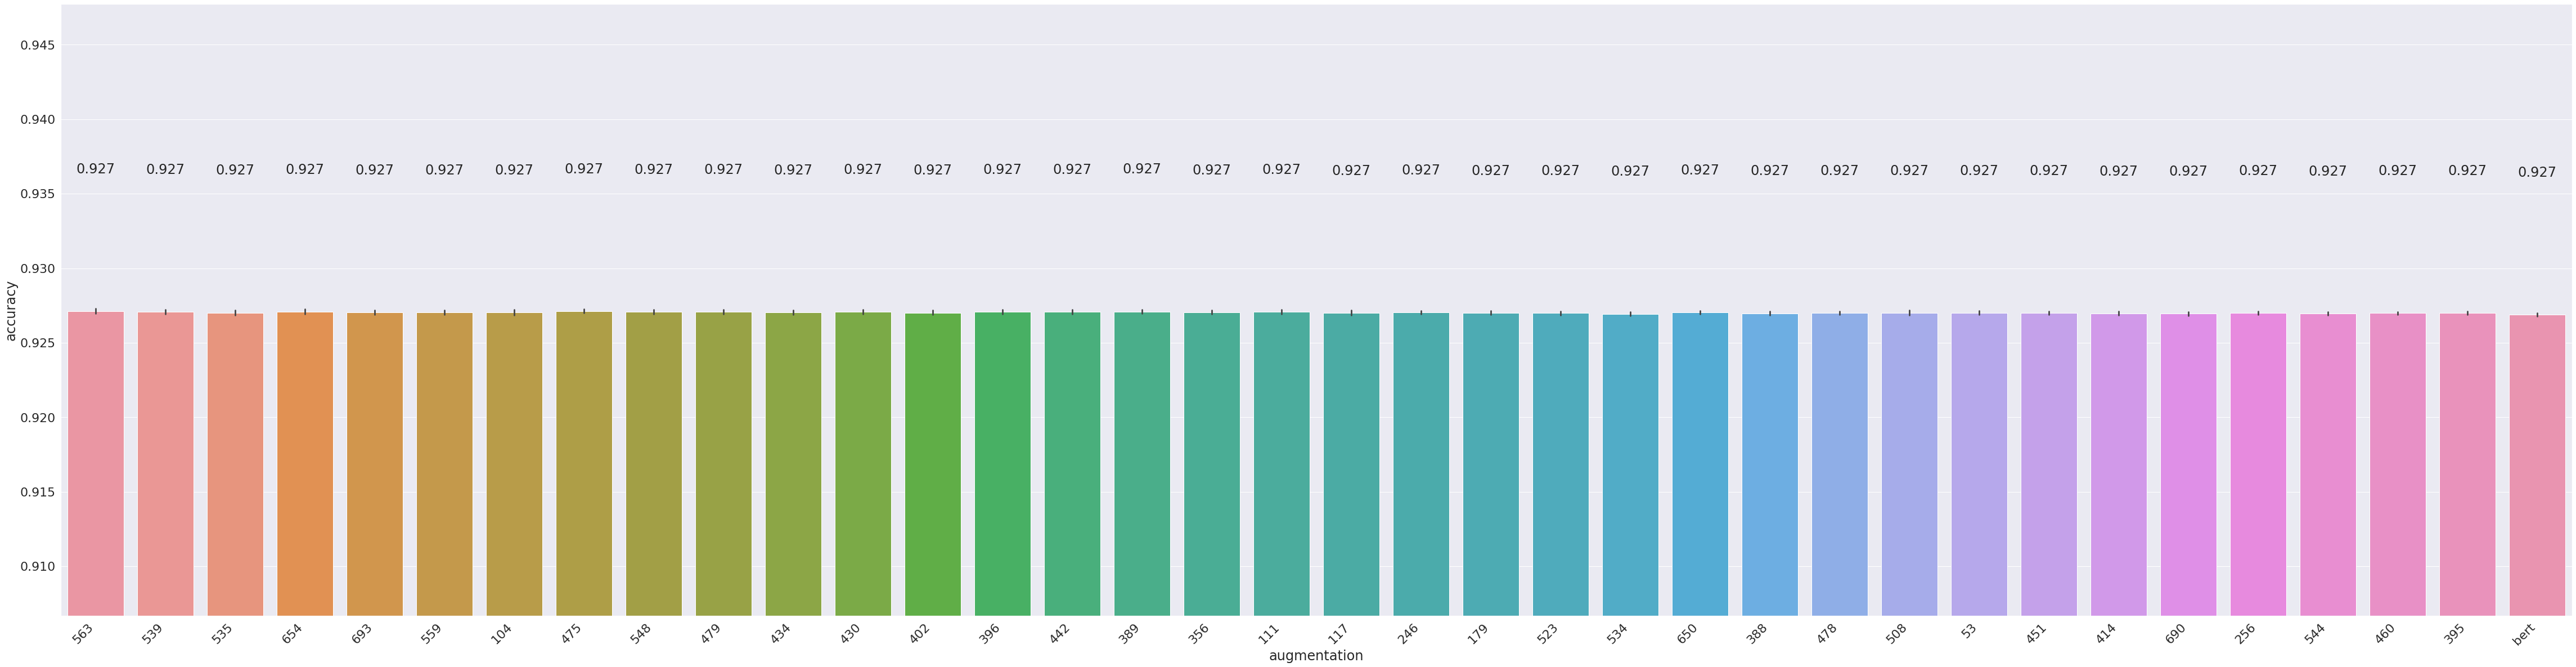

In [45]:
top_35_quads = df.groupby("augmentation", as_index = False).mean().sort_values(by=['accuracy'], ascending=False)[:35]
top_35_quad_ids = top_35_quads["augmentation"].tolist()



plotted_accuracies = []

directory = './data/civilcomments_ERM_predictions_optimized_params/single_sample_four_optimized_aug/word_based/'

for quad in top_35_quad_ids:
    file = directory + str(quad) + ".npy"
    plotted_accuracies.append(file)


plotted_accuracies.append('./data/civilcomments_ERM_predictions/bert.npy')


top_35_df = create_accuracy_graph(plotted_accuracies, "bar", num_runs = 10)

In [57]:
with open("./data/civilcomments_ERM_predictions_optimized_params/single_sample_four_optimized_aug/word_based/combo_id_to_combo.txt", 'r') as file:
    combo_dict = json.load(file)
    
combo_id_to_combo_name = {}

directory = './data/civilcomments_ERM_predictions_optimized_params/single_sample_four_optimized_aug/word_based/'

for combo_id in top_35_quad_ids:
    improved_combo = combo_dict[str(combo_id)]
    
    combo_id_to_combo_name[combo_id] = improved_combo

combo_names = pd.DataFrame(combo_id_to_combo_name).transpose()
    
combo_names


,0,1,2,3,4
396,nlp_random_contextual_word_insertion_distilber...,nlp_antonym,nlp_random_word_swap,nlp_random_token_split,bert
430,nlp_random_contextual_word_insertion_distilber...,nlp_random_contextual_word_insertion_distilber...,nlp_random_contextual_word_insertion_distilrob...,nlp_random_token_split,bert
475,nlp_random_contextual_word_insertion_distilber...,nlp_random_contextual_word_insertion_distilrob...,nlp_random_word_substitute,nlp_ppdb_synonym,bert
539,nlp_antonym,nlp_random_word_swap,nlp_random_contextual_word_insertion_distilrob...,nlp_ppdb_synonym,bert
402,nlp_random_contextual_word_insertion_distilber...,nlp_antonym,nlp_random_contextual_word_insertion_distilrob...,nlp_random_token_split,bert
479,nlp_random_contextual_word_insertion_distilber...,nlp_random_contextual_word_insertion_distilrob...,nlp_random_token_split,nlp_ppdb_synonym,bert
650,nlp_random_word_swap,nlp_random_contextual_word_insertion_distilrob...,nlp_random_word_substitute,nlp_ppdb_synonym,bert
548,nlp_antonym,nlp_random_word_swap,nlp_random_token_split,nlp_ppdb_synonym,bert
478,nlp_random_contextual_word_insertion_distilber...,nlp_random_contextual_word_insertion_distilrob...,nlp_random_token_split,nlp_wordnet_synonym,bert
563,nlp_antonym,nlp_random_contextual_word_insertion_distilrob...,nlp_random_token_split,nlp_ppdb_synonym,bert


In [21]:
plotted_accuracies = []

directory = './data/ERM_predictions_optimized_params/single_sample_four_optimized_aug/word_based/'
for file in os.listdir(directory):
    if file.split('.')[-1] == 'npy':
        plotted_accuracies.append(directory + file)



plotted_accuracies.append('./data/civilcomments_ERM_predictions/bert.npy')


df_2 = create_accuracy_graph(plotted_accuracies, "bar", sampling_percent = 0.2, num_runs = 5)

FileNotFoundError: [Errno 2] No such file or directory: './data/ERM_predictions_optimized_params/single_sample_four_optimized_aug/word_based/'

In [19]:
df_2

,augmentation,accuracy,batch_num
3435,545,0.930034,0
2065,651,0.929997,0
2705,396,0.929960,0
2625,616,0.929960,0
2900,535,0.929960,0
...,...,...,...
2916,429,0.927082,1
1256,411,0.927082,1
1433,359,0.927082,3
456,145,0.927082,1


In [21]:
df_2["augmentation"].nunique()

716

In [60]:
import random


dataset_size = len(get_eval_dataset("civilcomments", "ERM"))

def select_random_indices(seed, dataset_size, sampling_percent = 0.8):
    random.seed(seed)
    number_of_indices = int(sampling_percent * dataset_size)
    
    return random.sample(range(0, dataset_size), number_of_indices)



def accuracy_t_test(augmentation_file, baseline_file, sampling_percent = 0.8, num_subsamples = 10, num_samples = 4, with_bert = True):
    
    aug_accuracies = []
    baseline_accuracies = []
    
    aug_logit_predictions = []
    aug_labels = []
    
    baseline_logit_predictions = []
    baseline_labels = []
    
    with open(augmentation_file, 'rb') as file:
        aug_logit_predictions = np.load(file, allow_pickle = True)
        aug_labels = np.load(file, allow_pickle = True)
        
    with open(baseline_file, 'rb') as file:
        baseline_logit_predictions = np.load(file, allow_pickle = True)
        baseline_labels = np.load(file, allow_pickle = True)


    for i in tqdm(range(num_subsamples)):
        indices = select_random_indices(i, dataset_size, sampling_percent = sampling_percent)


        rand_baseline_logit_predictions = np.take(baseline_logit_predictions, indices, axis = 0)
        
        matching_baseline_labels = np.take(baseline_labels, indices)
        
        multi_sample_indices = []

        for index in indices:
            scaled_index = num_samples * index
            
            multi_sample_indices.append(scaled_index)
            
            multi_sample_indices.extend(scaled_index + i for i in range(1, num_samples))
        
        rand_aug_logit_predictions = np.take(aug_logit_predictions, multi_sample_indices, axis = 0)
        matching_aug_labels = np.take(aug_labels, multi_sample_indices)

        
        
        assert matching_baseline_labels.all() == matching_aug_labels[::num_samples].all(), "Labels do not match."
        
        classified_aug_predictions = []
        
        start = 0
        stop = num_samples
        num_comments = int(len(rand_aug_logit_predictions)/num_samples)

        for i in range(num_comments):
            start = i*num_samples
            stop = (i+1)*num_samples 

            sample_group = rand_aug_logit_predictions[start:stop]

            if with_bert:
                baseline_logit_prediction = rand_baseline_logit_predictions[i]
                sample_group = np.vstack([sample_group, baseline_logit_prediction])

            sample_logit_average = np.average(sample_group, axis = 0)
            index_prediction = np.argmax(sample_logit_average, axis = 0).tolist()
            classified_aug_predictions.append(index_prediction)
            

            start += num_samples
            stop += num_samples
        
        

        
        classified_baseline_predictions = []
        for prediction in rand_baseline_logit_predictions:
            index_prediction = np.argmax(prediction, axis = 0).tolist()
            classified_baseline_predictions.append(index_prediction)
        
        
        baseline_score = sklearn.metrics.accuracy_score(matching_baseline_labels, classified_baseline_predictions)
        baseline_accuracies.append(baseline_score)
        
        aug_score = sklearn.metrics.accuracy_score(matching_baseline_labels, classified_aug_predictions)
        aug_accuracies.append(aug_score)
        
    
    t_test_score = sp.stats.ttest_rel(baseline_accuracies, aug_accuracies)
    
    subsample_acc_diff = [aug_accuracies[i] - baseline_accuracies[i] for i in range(len(aug_accuracies))]
    mean_acc_diff = statistics.mean(subsample_acc_diff)
    
    return(t_test_score, mean_acc_diff)

    

char_min: 1
word_p: 0.1


In [110]:
accuracy_t_test('./data/civilcomments_ERM_predictions_optimized_params_four_samples/raw/nlp_spelling_substitution.npy'
               , './data/ERM_predictions/bert.npy'
               , num_subsamples = 10).pvalue

  0%|          | 0/10 [00:00<?, ?it/s]

9.261496459116255e-17

In [62]:
multi_sample_improved_augs = [
 'nlp_spelling_substitution'
 , 'nlp_random_char_deletion'
 , 'nlp_random_contextual_word_insertion_distilroberta_base_embedding'
 , 'nlp_random_contextual_word_insertion_roberta_base_embedding'
 , 'nlp_random_contextual_word_insertion_distilbert_uncased_embedding'
 , 'nlp_random_contextual_word_insertion_bert_cased_embedding'
 , 'nlp_random_word_swap'
 , 'nlp_random_contextual_word_insertion_squeezebert_uncased_embedding'
 , 'nlp_random_contextual_word_insertion_bart_base_embedding'
 , 'nlp_wordnet_synonym'
 , 'nlp_random_word_delete'
 , 'nlp_ppdb_synonym'
 , 'nlp_random_contextual_word_substitution_bert_uncased_embedding'
 , 'nlp_antonym'
 , 'nlp_random_word_substitute'
]

t_test_scores = []

for aug in multi_sample_improved_augs:
    stat = {}
    
    path = './data/civilcomments_ERM_predictions_optimized_params_four_samples/raw/' + aug + '.npy'
    
    t_score, mean_perc_diff = accuracy_t_test(path
                             , './data/civilcomments_ERM_predictions/bert.npy'
                             , num_subsamples = 10)
    
    p_value = t_score.pvalue
    t_stat = t_score.statistic
    
    stat["augmentation"] = aug
    stat["p-value"] = p_value
    stat["t-statistic"] = t_stat
    stat["mean accuracy diff"] = mean_perc_diff
    
    t_test_scores.append(stat)
    


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [63]:
pd.DataFrame(t_test_scores)

,augmentation,p-value,t-statistic,mean accuracy diff
0,nlp_spelling_substitution,4.810102e-12,-46.622682,0.005897
1,nlp_random_char_deletion,9.682238e-01,0.040958,-0.000005
2,nlp_random_contextual_word_insertion_distilrob...,2.563390e-13,-64.635379,0.008303
3,nlp_random_contextual_word_insertion_roberta_b...,3.999959e-13,-61.511301,0.008205
4,nlp_random_contextual_word_insertion_distilber...,1.390774e-13,-69.188003,0.007989
5,nlp_random_contextual_word_insertion_bert_case...,1.451184e-12,-53.286104,0.007839
6,nlp_random_word_swap,4.745785e-13,-60.351275,0.007844
7,nlp_random_contextual_word_insertion_squeezebe...,6.376857e-13,-58.397997,0.007619
8,nlp_random_contextual_word_insertion_bart_base...,3.299179e-13,-62.844747,0.007480
9,nlp_wordnet_synonym,1.418579e-12,-53.421205,0.006866


In [ ]:
# Only use the ones whose single sample augmentation had higher performance
# Top 5 across word and character single-sample experiment and then do the 4-samples 
# Multi sample, multi-aug

